In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import seaborn as sn
import statsmodels.formula.api as smf
from IPython.display import Image

plt.style.use('ggplot')

In [2]:
# Connect to Oracle
eng = nivapy.da.connect()

Connection successful.


# MARTINI - Process Norwegian river data

This notebook generates a dataset of riverine inputs to Skagerrak from 23 major Norwegian rivers. It builds upon the data exploration originally described in [this notebook](http://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/water_chem.ipynb). The aim is to generate a complete dataset of daily nutrient concentrations covering the period from 2015 to 2017 inclusive. The following parameters are of interest: NH4, NO3, TON, Tot-N, SRP, TOP, Tot-P, DOC and TOC. These basic quantities can then be further subdived according to the requirements of the marine model.

I have already extracted water quality data for as many rivers as possible from [Vannmiljø](https://vannmiljo.miljodirektoratet.no/). Based on the preliminary data exploration described in the [previous notebook](http://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/water_chem.ipynb), I think the following workflow seems like the best strategy:

 1. **Concentration-discharge relationships for each site**
 
 Regress Tot-N, Tot-P and TOC against flow for each site, using all the data available between 2000 and 2018. Use these relationships to estimate complete daily time series for these parameters for 2015 to 2017.  
 
 2. **Concentration-concentration relationships for the dataset as a whole**
 
 Many of the sites do not have enough data for NH4, NO3, SRP or DOC to be able to derive C-Q relationships directly. Instead, I will pool all the data and estimate "overall" regressions between the following parameters:
  
  * NH4 vs. Tot-N
  * NO3 vs. Tot-N
  * SRP vs. Tot-P
  * DOC vs. TOC <br><br>
  
 Time series for these varaiables can then be estimated from the Tot-N, Tot-P and TOC series calculated in step 1. The [exploratory notebook](http://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/water_chem.ipynb) indicates this will work OK for NO3 and DOC, but results for NH4 and SRP will likely be poor.

 3. **Estimate other parameters of interest**
 
 Additional model parameters must be estimated from the daily series:
 
  * Calculate organic N: $TON = TotN - NH4 - NO3$
  * Decide on what to do about other P species. The best approach probably depends on how organic P is treated in the model (i.e. whether it is assumed to be readily available or not) <br><br> 
 
## 1. List Norwegian rivers

In [3]:
# Read Andre's list of rivers
riv_xlsx = r'../tidied_data_series/martini_river_outlets.xlsx'
riv_df = pd.read_excel(riv_xlsx, sheet_name='rivers')

# Filter to Norway
riv_df = riv_df.loc[riv_df['martini_code'].str.startswith('n')]

riv_df

,martini_id,station_name,resa_id,vannmiljo_id,mvm_id,lat,lon,martini_code
9,7,Haldenvassdraget,29830.0,001-38541,NaN,59.1187,11.3697,nmca001
10,9,Glomma-Vesterelva,29617.0,002-38516,NaN,59.1846,10.8819,nmca002
11,8,Glomma-Østerelva,29617.0,002-38516,NaN,59.1813,10.9527,nmca002
12,10,Mossevassdraget,30129.0,003-30718,NaN,59.4392,10.6610,nmca003
13,11,Hølenelva,30021.0,004-60940,NaN,59.5278,10.6900,nmca004
14,12,Årungelva,30023.0,005-38775,NaN,59.7223,10.7280,nmca005
15,13,Akerselva,30078.0,006-51732,NaN,59.9048,10.7538,nmca006
16,14,Lysakerelva,30082.0,007-56495,NaN,59.9115,10.6419,nmca007
17,15,Sandvikselva,30022.0,008-60878,NaN,59.8874,10.5288,nmca008
18,16,Årosvassdraget,30025.0,009-29296,NaN,59.7040,10.5201,nmca009


## 2. Read tidied chemistry data

The code below reads the tidied data for Norway created in the exploratory notebook.

In [4]:
# Read tidied Norwegian chem data from csv
csv_path = r'../tidied_data_series/martini_norway_chem_tidy.csv'
wc_df = pd.read_csv(csv_path)

# Convert dates ignoring times
wc_df['sample_date'] = pd.to_datetime(wc_df['sample_date']).dt.date

wc_df.head()

,vassnr,station_name,lon,lat,sample_date,par_unit,value
0,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,N-NH4_µg/l,21.0
1,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,N-NO3_µg/l,574.0
2,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,N-TOT_µg/l,936.0
3,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,SRP_µg/l,1.0
4,1,"Tista, utløp Femsjøen (FEMU)",11.444334,59.127828,2000-01-01,TOC_mg/l,7.1


## 3. Concentration-discharge relationships

### 3.1. Regression relationships

Section 2.1.5 of the [exploratory notebook](http://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/water_chem.ipynb) produced C-Q regression plots for each site. The code below calculates OLS regression equations and saves the coefficients for later use. Plots showing residuals for each site are [here](https://github.com/JamesSample/martini/tree/master/plots/flow_conc_reg_resid).

**Note:** The relationship between C and Q is typically non-linear, and it is usual to fit a model of the following form

$$log(C) = \beta_0 + \beta_1 log(Q) + \epsilon_i$$

In order to make predictions for $C$, it is therefore necessary to back-transform the regression, but this incurs **back-transformation bias**, which must be corrected. If the original data are transformed using **base-10** logarithms, [Ferguson (1987)](https://onlinelibrary.wiley.com/doi/abs/10.1002/esp.3290120111) suggested a correction factor, $\alpha$

$$E[C|Q] = \alpha 10^{\beta_0} Q^{\beta_1}$$

where 

$$\alpha = e^{2.615s^2}$$

and $s^2$ is the mean residual sum of squares from the regression. The maximum likelihood estimator for $s^2$ is 

$$s^2 = \frac{1}{N} \sum_i e_i^2$$

As an aside, the factor of 2.651 is due to converting between base-10 and base-e logs. In base-e, the correction factor is

$$\alpha = exp(s^2/2)$$

and for base-10 this becomes

$$\alpha = exp(s^2 (ln 10)^2 / 2) = exp(2.651 s^2)$$

In [5]:
# Simple OLS regression against flow
reg_dict = {}
for vass in wc_df['vassnr'].unique():
    # Skip sites with no data
    if vass not in (5, 10):
        # Get stn data
        df = wc_df.query('vassnr == @vass')
        
        # Set values equal to 0 to NaN (zeros cause log issues, and no lab 
        # method can actually report 0)
        df[df==0] = np.nan

        # Get RESA stn ID
        mar_cd = 'nmca%03d' % vass
        resa_id = riv_df.query('martini_code == @mar_cd')['resa_id'].iloc[0]

        # Get flow data from NIVABASE
        q_df = nivapy.da.extract_resa_discharge(resa_id,
                                                '2000-01-01',
                                                '2017-12-31',
                                                eng,
                                                plot=False)

        # Restructure chem
        df = df.sort_values(['sample_date', 'par_unit'])
        idx_cols = ['vassnr', 'station_name', 'lon', 'lat', 'sample_date', 'par_unit']
        df.set_index(idx_cols, inplace=True)
        df = df.unstack('par_unit').reset_index().sort_values('sample_date')
        df.index = df['sample_date']
        del df['vassnr'], df['station_name'], df['lon'], df['lat'], df['sample_date']
        df.columns = df.columns.get_level_values(1)

        # Get list of chem cols
        if vass == 4:
            # No TOC
            chem_cols = ['N-TOT_µg/l', 'P-TOT_µg/l']
        else:
            chem_cols = ['N-TOT_µg/l', 'P-TOT_µg/l', 'TOC_mg/l']

        # Join to Q
        df = df.join(q_df, how='left')
        
        # Get logged data (base-10)
        df2 = np.log10(df)
        df2.columns = ['log(%s)' % i for i in df2.columns]
        df = df.join(df2)

        # Regression
        for col in chem_cols:
            # OLS regression
            res = smf.ols(formula='Q("log(%s)") ~ Q("log(flow_m3/s)")' % col, data=df).fit()

            # Plot diagnotsics
            fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
            
            axes[0].plot(res.model.exog[:, 1], res.resid, 'ro')
            axes[0].set_xlabel('log[Flow (m3/s)]')
            axes[0].set_ylabel('Residual')
            
            sn.distplot(res.resid.values, ax=axes[1])
            axes[1].set_xlabel('Residual')
            
            plt.suptitle('%s at vassområde %03d' % (col.split('_')[0], vass))
            plt.tight_layout()
            
            # Save png
            png_path = r'../plots/flow_conc_reg_resid/vassnr_%03d_%s.png' % (vass, col.split('_')[0])
            plt.savefig(png_path, dpi=300)
            plt.close()  
        
            # Add to results
            reg_dict[(vass, col)] = res

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._where(-key, value, inplace=True)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which w

### 3.2. Calculate daily Tot-N, Tot-P and TOC

The code below uses the equations from Section 3.1 to estimate daily Tot-N, Tot-P and TOC from discharge.

**Note:** The code below uses the regression equations to estimate concentrations even for days when observations are available. It is easy to change this behaviour by uncommenting the penultimate line of code in the cell below, but including the observed data introduces some very sudden spikes in the water chemistry series. In general, the regressions do an OK job of simulating mean water chemistry values based on discharge, but they do not capture the full variability of the observed water chemistry series. As a consequence, combining the observed and estimated series introduces sudden changes, which may case artifacts in the marine model. I can change this later if desired.

In [6]:
# Loop over sites
data_dict = {}
for vass in wc_df['vassnr'].unique():
    # Skip sites with no data
    if vass not in (5, 10):
        # Get stn data
        df = wc_df.query('vassnr == @vass')
        
        # Set values equal to 0 to NaN (zeros cause log issues, and no lab 
        # method can actually report 0)
        df[df==0] = np.nan

        # Get RESA stn ID
        mar_cd = 'nmca%03d' % vass
        resa_id = riv_df.query('martini_code == @mar_cd')['resa_id'].iloc[0]

        # Get flow data from NIVABASE
        q_df = nivapy.da.extract_resa_discharge(resa_id,
                                                '2015-01-01',
                                                '2017-12-31',
                                                eng,
                                                plot=False)
        q_df = q_df.resample('D').mean()
        
        # Remove zeros and then interpolate again
        q_df[q_df==0] = np.nan
        q_df.interpolate(kind='linear', inplace=True)

        # Restructure chem
        df = df.sort_values(['sample_date', 'par_unit'])
        df.set_index(idx_cols, inplace=True)
        df = df.unstack('par_unit').reset_index().sort_values('sample_date')
        df.index = df['sample_date']
        del df['vassnr'], df['station_name'], df['lon'], df['lat'], df['sample_date']
        df.columns = df.columns.get_level_values(1)

        # Get list of chem cols
        if vass == 4:
            # No TOC
            chem_cols = ['N-TOT_µg/l', 'P-TOT_µg/l']
        else:
            chem_cols = ['N-TOT_µg/l', 'P-TOT_µg/l', 'TOC_mg/l']
            
        # Get just cols of interest
        df = df[chem_cols]

        # Join to Q
        df = q_df.join(df, how='left')
        
        # Loop over chem data
        for col in chem_cols:
            # Get regression result
            res = reg_dict[(vass, col)]
            
            # Calc C
            concs = (10**res.params[0])*(df['flow_m3/s']**res.params[1])

            # Back-transform
            alpha = np.exp(2.651*((res.resid.values)**2).mean())
            concs = alpha*concs
            
            # Update series
            df[col] = concs #df[col].fillna(concs)
            
            # Add to results
            data_dict[vass] = df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


## 4. Concentration-concentration relationships

### 4.1. Regression relationships

The tables below show summary statistics for each regression. Note that **I've removed the intercept term** (unlike on the rough plots in the [exploratory notebook](http://nbviewer.jupyter.org/github/JamesSample/martini/blob/master/notebooks/water_chem.ipynb)), as it seems sensible to fix the intercept at the origin for all these models.

In [7]:
# Restructure chem
df = wc_df.copy()
df = df.sort_values(['vassnr', 'sample_date', 'par_unit'])
df.set_index(idx_cols, inplace=True)
df = df.unstack('par_unit').reset_index().sort_values(['vassnr', 'sample_date'])
del df['station_name'], df['lon'], df['lat']
df.columns = df.columns.get_level_values(1)
cols = list(df.columns)
cols[:2] = ['vassnr', 'sample_date']
df.columns = cols

# Filter obviously contaminated P sample
df = df[df['P-TOT_µg/l']<3000]

### 4.1.1. NH4 vs. Tot-N

$R^2 \approx 38\%$

$p \approx 0$

$NH_4 \approx 0.038*TotN$

In [8]:
# NH4
nh4_reg = smf.ols(formula='Q("N-NH4_µg/l") ~ Q("N-TOT_µg/l") - 1', data=df).fit()
print(nh4_reg.summary())

                            OLS Regression Results                            
Dep. Variable:        Q("N-NH4_µg/l")   R-squared:                       0.378
Model:                            OLS   Adj. R-squared:                  0.377
Method:                 Least Squares   F-statistic:                     1857.
Date:                Tue, 18 Dec 2018   Prob (F-statistic):          1.78e-317
Time:                        13:51:34   Log-Likelihood:                -14669.
No. Observations:                3062   AIC:                         2.934e+04
Df Residuals:                    3061   BIC:                         2.935e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Q("N-TOT_µg/l")     0.0384      0.001     

### 4.1.2. NO3 vs. Tot-N

$R^2 \approx 94\%$

$p \approx 0$

$NO_3 \approx 0.57*TotN$

In [9]:
# NO3
no3_reg = smf.ols(formula='Q("N-NO3_µg/l") ~ Q("N-TOT_µg/l") - 1', data=df).fit()
print(no3_reg.summary())

                            OLS Regression Results                            
Dep. Variable:        Q("N-NO3_µg/l")   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 2.192e+04
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:51:36   Log-Likelihood:                -8353.8
No. Observations:                1484   AIC:                         1.671e+04
Df Residuals:                    1483   BIC:                         1.671e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Q("N-TOT_µg/l")     0.5662      0.004    1

### 4.1.3. SRP vs. Tot-P

$R^2 \approx 50\%$

$p \approx 0$

$SRP \approx 0.29*TotP$

In [10]:
srp_reg = smf.ols(formula='Q("SRP_µg/l") ~ Q("P-TOT_µg/l") - 1', data=df).fit()
print(srp_reg.summary())

                            OLS Regression Results                            
Dep. Variable:          Q("SRP_µg/l")   R-squared:                       0.499
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     3281.
Date:                Tue, 18 Dec 2018   Prob (F-statistic):               0.00
Time:                        13:51:38   Log-Likelihood:                -11792.
No. Observations:                3295   AIC:                         2.359e+04
Df Residuals:                    3294   BIC:                         2.359e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Q("P-TOT_µg/l")     0.2877      0.005     

### 4.1.4. DOC vs. TOC

$R^2 \approx 100\%$

$p \approx 0$

$DOC \approx 0.97*TOC$

In [11]:
doc_reg = smf.ols(formula='Q("DOC_mg/l") ~ Q("TOC_mg/l") - 1', data=df).fit()
print(doc_reg.summary())

                            OLS Regression Results                            
Dep. Variable:          Q("DOC_mg/l")   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.157e+05
Date:                Tue, 18 Dec 2018   Prob (F-statistic):          1.26e-208
Time:                        13:51:40   Log-Likelihood:                 74.230
No. Observations:                 143   AIC:                            -146.5
Df Residuals:                     142   BIC:                            -143.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Q("TOC_mg/l")     0.9693      0.003    340.163

### 4.2. Estimate NH4, NO3, SRP and DOC

In [12]:
# Loop over sites
for vass in data_dict.keys():
    # Get data
    df = data_dict[vass]
    
    # Calc params
    if 'N-TOT_µg/l' in df.columns:
        df['N-NH4_µg/l'] = nh4_reg.params[0]*df['N-TOT_µg/l']
        df['N-NO3_µg/l'] = no3_reg.params[0]*df['N-TOT_µg/l']
        
    if 'P-TOT_µg/l' in df.columns:
        df['SRP_µg/l'] = srp_reg.params[0]*df['P-TOT_µg/l']
        
    if 'TOC_mg/l' in df.columns:
        df['DOC_mg/l'] = doc_reg.params[0]*df['TOC_mg/l']
        
    # Update results
    data_dict[vass] = df

## 5. Estimate other parameters of interest

Time series plots of the final daily series can be found [here](https://github.com/JamesSample/martini/tree/master/plots/daily_series). An illustrative example is shown below.

In [13]:
# Loop over sites
df_list = []
for vass in data_dict.keys():
    # Get data
    df = data_dict[vass]
    
    # Calc. TON
    df['N-TON_µg/l'] = df['N-TOT_µg/l'] - df['N-NH4_µg/l'] - df['N-NO3_µg/l']
    
    # Plot
    df.plot(subplots=True, 
            layout=(3,3), 
            figsize=(15,10),
            legend=False,
            title=list(df.columns))
    
    plt.tight_layout()

    # Save png
    png_path = r'../plots/daily_series/vassnr_%03d.png' % vass
    plt.savefig(png_path, dpi=300)
    plt.close() 
    
    # Tidy
    cols = list(df.columns)
    df.reset_index(inplace=True)
    df['vassnr'] = vass
    df = df[['vassnr', 'date'] + cols]
    
    # Add to output
    df_list.append(df)
    
# Combine
df = pd.concat(df_list, axis=0, sort=False)

# Write output
csv_path = r'../tidied_data_series/nor_daily_water_chem.csv'
df.to_csv(csv_path, index=False, encoding='utf-8')

df.head()

,vassnr,date,flow_m3/s,N-TOT_µg/l,P-TOT_µg/l,TOC_mg/l,N-NH4_µg/l,N-NO3_µg/l,SRP_µg/l,DOC_mg/l,N-TON_µg/l
0,1,2015-01-01,23.146906,838.339043,15.842753,8.482895,32.172781,474.685700,4.557375,8.222374,331.480562
1,1,2015-01-02,40.579857,851.189078,16.302417,8.556124,32.665925,481.961668,4.689603,8.293354,336.561486
2,1,2015-01-03,38.858033,850.189708,16.266447,8.550446,32.627572,481.395802,4.679256,8.287851,336.166333
3,1,2015-01-04,30.386127,844.543258,16.063918,8.518312,32.410879,478.198661,4.620996,8.256703,333.933718
4,1,2015-01-05,28.937313,843.426052,16.023986,8.511943,32.368004,477.566074,4.609509,8.250529,333.491973


Estimated daily series for vassdragområde 25.


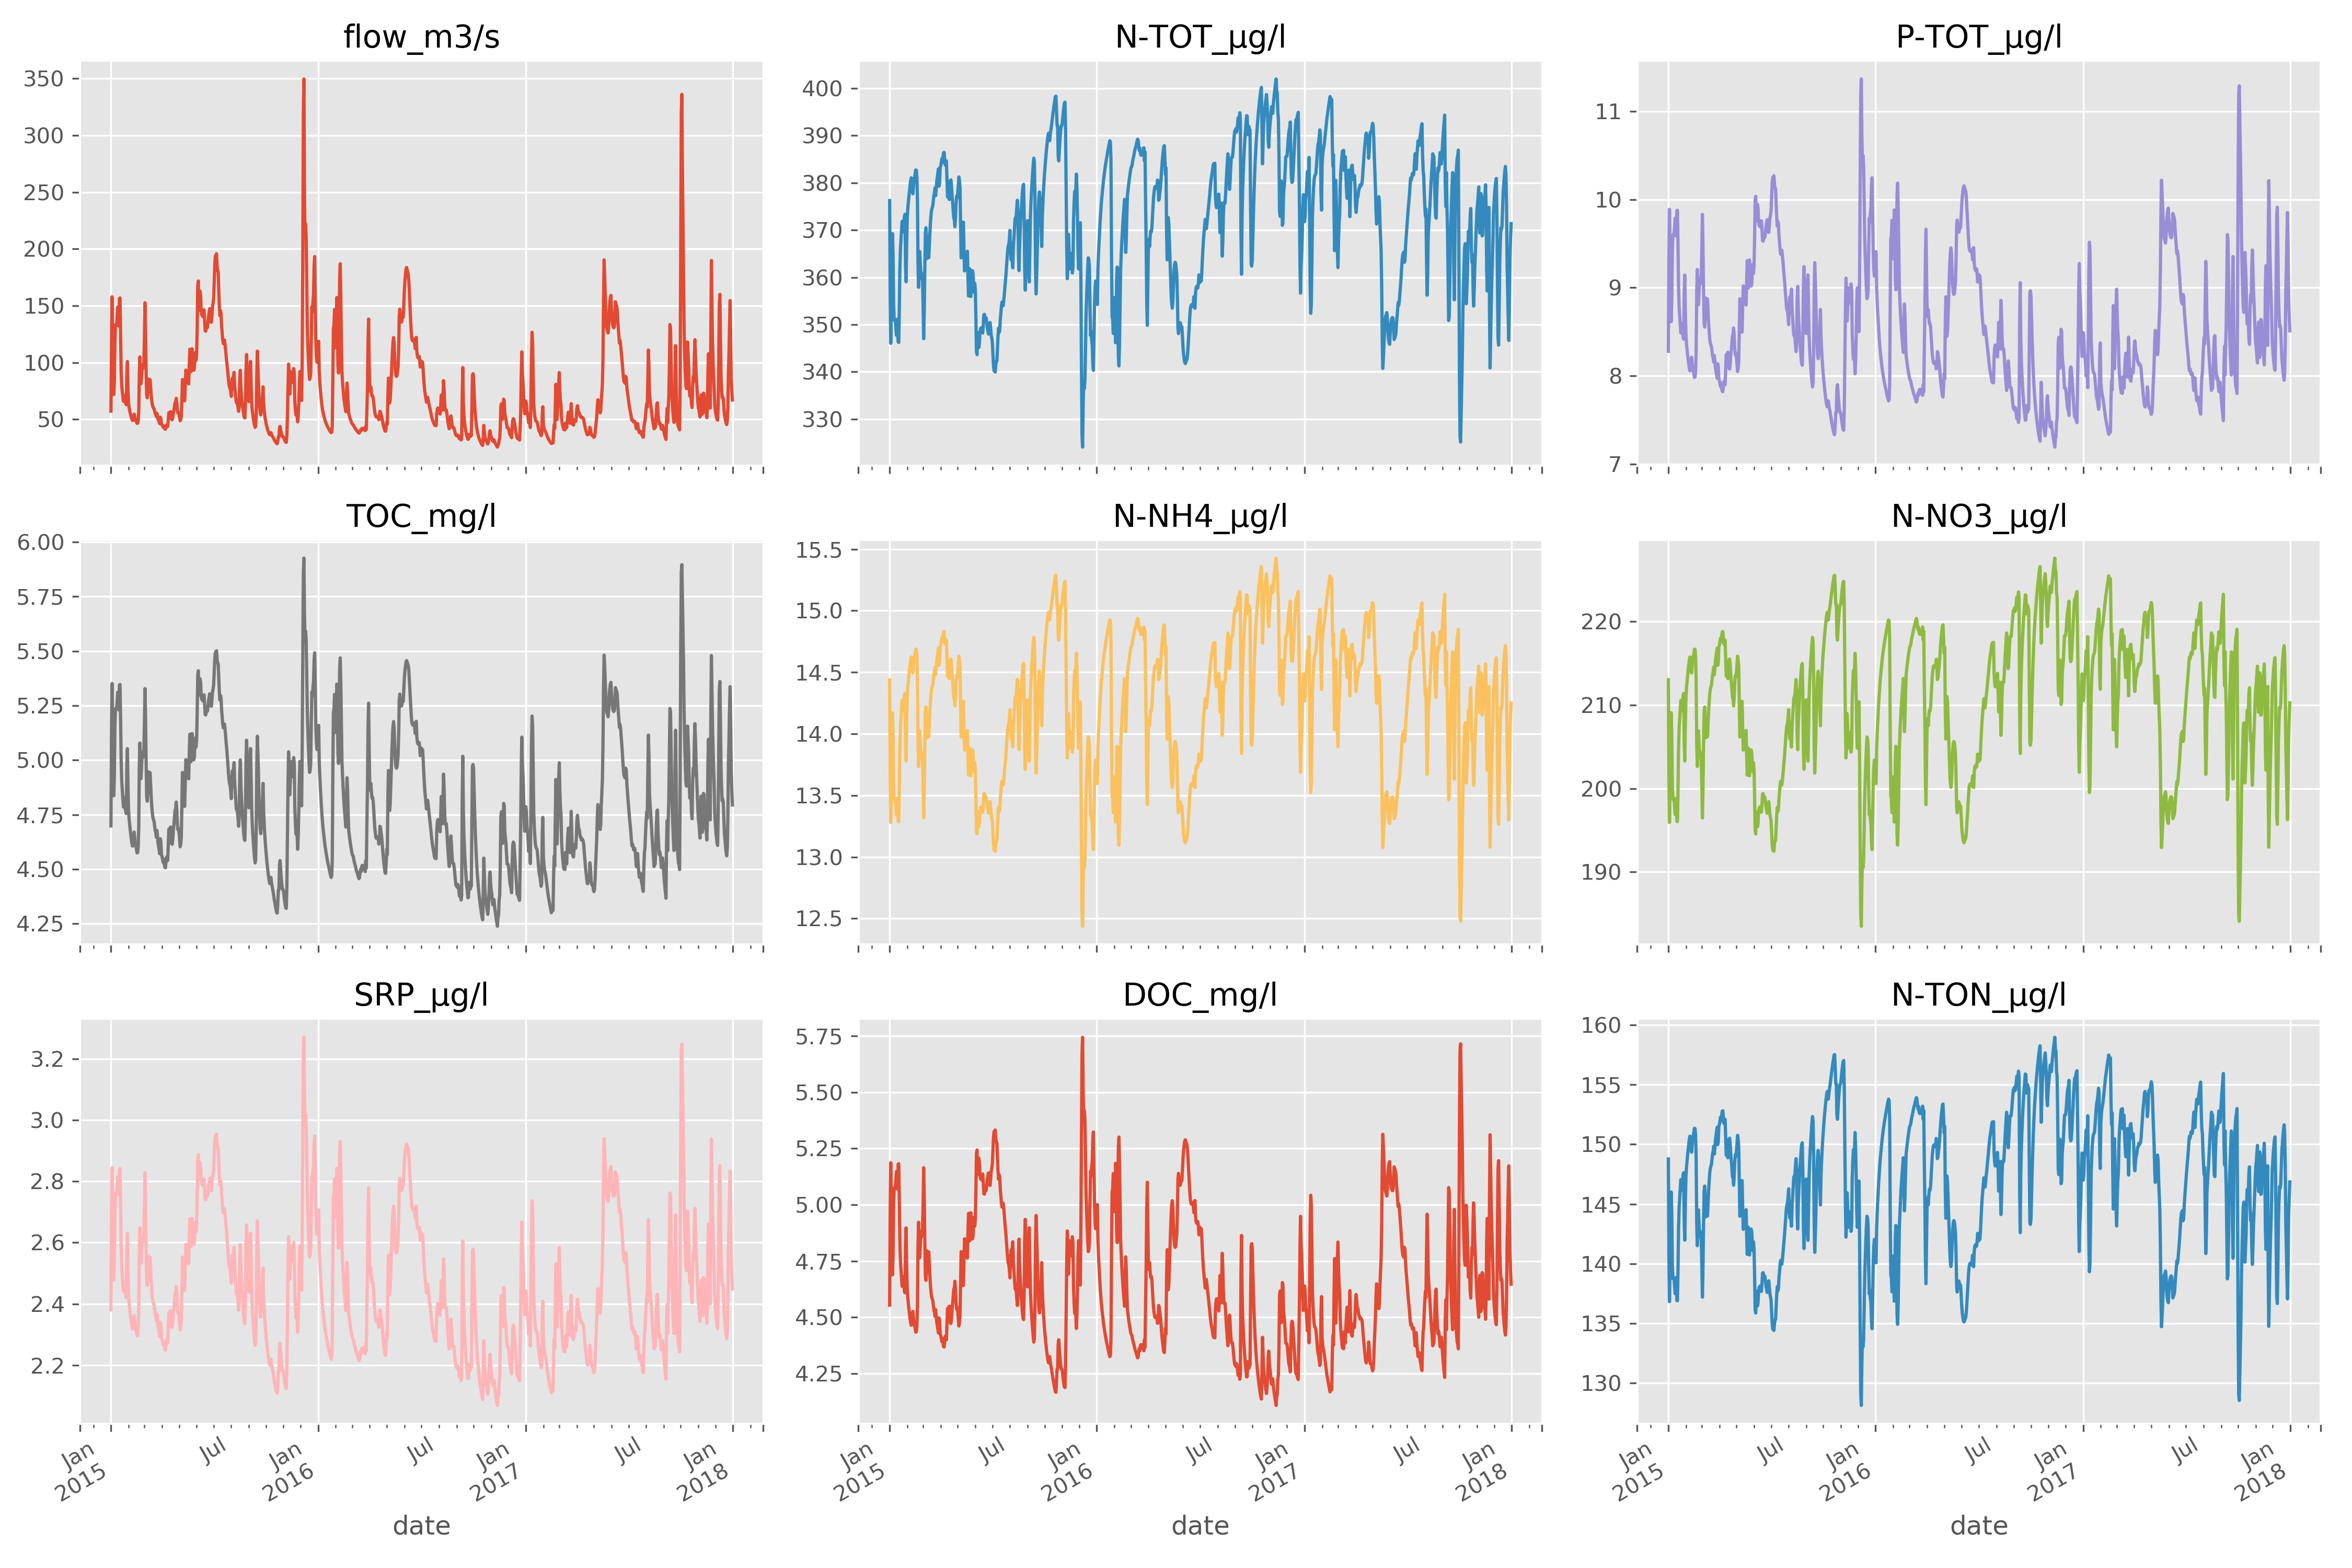

In [14]:
# Show example image
print ('Estimated daily series for vassdragområde %s.' % vass)
Image(png_path)